### 🧠 Answer Synthesis from Multiple Sources
✅ What Is It?

Answer synthesis from multiple sources is the process where an AI agent collects information from different retrieval tools or knowledge bases, and merges that information into a single, coherent, and contextually rich answer.

This is a core capability in Agentic RAG, where the system is more than just a simple retriever — it plans, retrieves, and then synthesizes an answer that draws from multiple sources.



🎯 Why It’s Needed
Most real-world queries are:
- Multifaceted (require multiple types of information)
- Ambiguous or incomplete (need refinement)
- Open-ended (don’t map to a single document or source)

🔍 This makes retrieving from a single vector DB insufficient.

Instead, we want an agent that can:

- Decide what to fetch from where (retrieval planning)
- Retrieve content from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
- Evaluate and merge that context
- Produce a single human-like response

In [17]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

In [18]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

llm=init_chat_model("groq:openai/gpt-oss-20b")

In [26]:
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, HuggingFaceEmbeddings())
    return vs.as_retriever()

def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc], HuggingFaceEmbeddings())
    return vectorstore.as_retriever()



def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(query)

def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    try:
        results = ArxivLoader(query).load()
        return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."
    except Exception as e:
        print(f"ArXiv search failed: {e}")
        return "ArXiv search unavailable. Mock result: Recent research on transformer agents includes work on reasoning, tool use, and autonomous planning."

In [27]:
text_retriever = load_text_retriever("research_notes.txt")
youtube_retriever = load_youtube_retriever()

In [28]:
### state
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = []
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

In [29]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

In [30]:
## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context += "\n\n[Wikipedia]\n" + state.wiki_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"final_answer": answer})

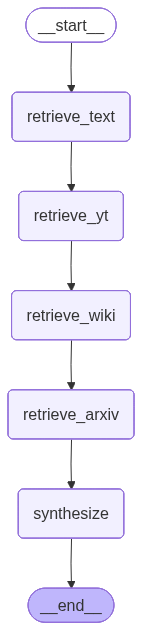

In [31]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [32]:
question = "What are transformer agents and how are they evolving in recent research?"
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])


🌐 Searching Wikipedia...
📄 Searching ArXiv...
ArXiv search failed: PyMuPDF package not found, please install it with `pip install pymupdf`
📄 Searching ArXiv...
ArXiv search failed: PyMuPDF package not found, please install it with `pip install pymupdf`
✅ Final Answer:

**Transformer agents** are a new class of AI systems that combine the raw representational power of large transformer‑based language models (LLMs) with the ability to *act* in an environment, *plan*, *remember*, and *use external tools*.  In practice they are usually built by taking a pre‑trained LLM, adding a small policy network (often the LLM itself), and training that policy to select actions that maximize a reward signal.  The actions can be anything that the system can “call” – from writing a line of code, to querying a database, to sending an HTTP request, or simply generating the next text token.

---

## 1.  What a transformer agent actually looks like

| Component | Typical implementation | Role |
|-----------|

In [34]:
result

{'question': 'What are transformer agents and how are they evolving in recent research?',
 'text_docs': [Document(id='6d4b5faa-d1a7-4406-aa70-2607541036ca', metadata={'source': 'research_notes.txt'}, page_content='Key papers/reading (suggested)\n- "Attention Is All You Need"\n- "Scaling Laws for Neural Language Models"\n- "Language Models are Few-Shot Learners"\n- "Chain of Thought Prompting"\n- "Retrieval-Augmented Generation (RAG)"\n- "Reinforcement Learning from Human Feedback (RLHF)"\n- Survey papers on efficient / sparse Transformers'),
  Document(id='c2250d1e-dd9b-447f-b40e-ee828f3f2c9a', metadata={'source': 'research_notes.txt'}, page_content='LLMs and Transformers — Research Notes\n=====================================\n\nOverview\n- Large Language Models (LLMs) are deep neural networks trained on massive text corpora to model natural language via next-token or masked token prediction.\n- Transformers replaced RNNs/CNNs with attention mechanisms, enabling parallelization and lo